### Цель работы:

изучение алгоритмов и методов кластеризации на практике.
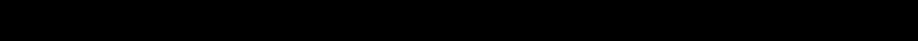
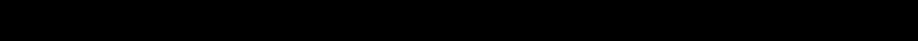

### Порядок выполнения работы:

1. Использовать функцию для создания набора данных
2. Получить с помощью функции набор данных
3. Провести стандартизацию данных
4. С помощью метода .fit_predict обучить модель для кластеризации методом Kmeans для трёх кластеров. Выполнить предсказание. Получить метки кластеров.
5. Провести визуализацию кластеров с помощью scatter. Построить графики. Пометить
на графике центры кластеров. Покрасить объекты из разных кластеров разными
цветами.
6. Посчитать коэффициент силуэта.
7. Повторить пункты 4-6 для n_clusters = 2 и n_clusters = 4 . Сравнить результаты и сделать
выводы.
8. Построить график по “методу локтя” и сделать выводы
9. Выполнить кластеризацию по вариантам

### Вариант задания - 3


Набор данных

_ecommerce_fraud.csv_

Данные содержат информацию о мошеннических транзакциях:
* transaction_amount — сумма транзакции, USD, числовой (логнормальное
распределение, возможны крупные суммы).
* device_type — тип устройства: Desktop / Mobile / Tablet, категориальный.
* browser — браузер: Chrome / Safari / Firefox / Edge / Other, категориальный.
* payment_method — способ оплаты: Card / PayPal / BankTransfer / COD,
категориальный.
* country — страна покупателя: US / UK / DE / FR / IN / BR / CN / Other,
категориальный.
* num_items — количество товаров в заказе, целочисленный (1–7).
* time_on_site_sec — время на сайте до покупки, секунды, числовой.
* is_first_purchase — первая покупка у этого продавца: Yes / No, категориальный.
* referral — источник трафика: Direct / Search / Social / Ads, категориальный.
* hour_of_day — час суток оформления заказа (0–23), целочисленный.
* account_age_days — «возраст» аккаунта, в днях, числовой.
* Fraud — целевой класс: 1 — мошенническая транзакция, 0 — нормальная


---

### Загрузка данных

Для начала были импортированы все необходимые для выполнения работы библиотеки, а именно:

pandas — для работы с табличными данными

numpy — для математических операций и работы с массивами

matplotlib и seaborn — для визуализации данных

sklearn — для алгоритмов машинного обучения и метрик

scipy — для иерархической кластеризации

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score

from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

Была выполнена загрузка датасета для кластеризации из файла 'ecommerce_fraud.csv'. Датасет содержит 3000 строк.

In [195]:
df = pd.read_csv('ecommerce_fraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_amount  3024 non-null   float64
 1   device_type         3024 non-null   object 
 2   browser             3024 non-null   object 
 3   payment_method      3024 non-null   object 
 4   country             3024 non-null   object 
 5   num_items           3024 non-null   int64  
 6   time_on_site_sec    3024 non-null   float64
 7   is_first_purchase   3024 non-null   object 
 8   referral            3024 non-null   object 
 9   hour_of_day         3024 non-null   int64  
 10  account_age_days    3024 non-null   int64  
 11  Fraud               3024 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 283.6+ KB


---

### 1. Предобработка данных

В датасете нет пропущенных значений.

In [196]:
df.isnull().sum()

transaction_amount    0
device_type           0
browser               0
payment_method        0
country               0
num_items             0
time_on_site_sec      0
is_first_purchase     0
referral              0
hour_of_day           0
account_age_days      0
Fraud                 0
dtype: int64

В датасете нет дубликатов.

In [197]:
df.duplicated().sum()

np.int64(0)

Все данные имеют правильный тип данных согласно описанию.

In [198]:
df.dtypes

transaction_amount    float64
device_type            object
browser                object
payment_method         object
country                object
num_items               int64
time_on_site_sec      float64
is_first_purchase      object
referral               object
hour_of_day             int64
account_age_days        int64
Fraud                   int64
dtype: object

---

Создан синтетический датасет из трёх кластеров по 50 точек каждый.

In [199]:
n = 50  # количество точек в каждом кластере
seed = 42  # для воспроизводимости

np.random.seed(seed)

shift_matrix = np.array([[3, 3],
                         [6, 9],
                         [9, 3]])

data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))

data = np.swapaxes(data, 1, 2)
data = data.reshape((-1, 2))

data *= np.array([[20, 0.5]])

df_synth = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]})
df_synth = df_synth.sample(frac=1.0, random_state=seed)

Получен синтетический набор данных, содержащий 150 объектов, распределённых в трёх чётко различимых кластерах. На графике видно три компактные группы точек вокруг красных звёзд (исходные центры кластеров). Данные идеально подходят для проверки алгоритмов кластеризации, так как имеют явную групповую структуру.

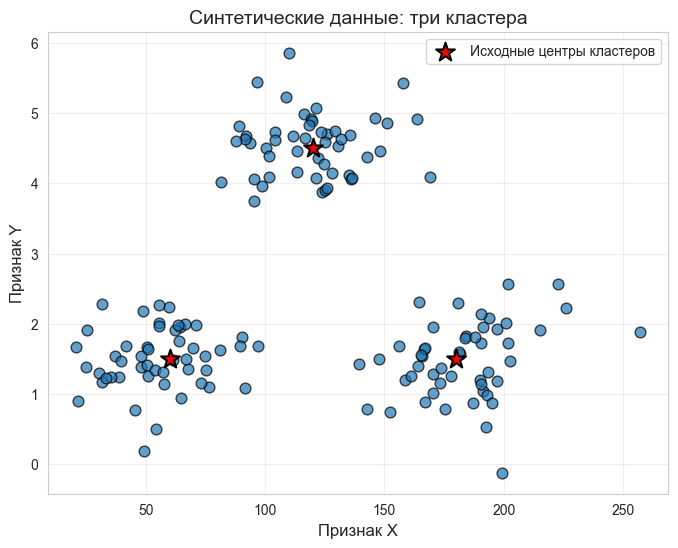

Общее количество точек: 150
Размерность данных: (150, 2)
Диапазон значений X: [20.8, 257.1]
Диапазон значений Y: [-0.1, 5.9]


In [200]:
# Визуализация полученного набора данных
plt.figure(figsize=(8, 6))
plt.scatter(df_synth['x'], df_synth['y'], alpha=0.7, edgecolors='k', s=60)
plt.title('Синтетические данные: три кластера', fontsize=14)
plt.xlabel('Признак X', fontsize=12)
plt.ylabel('Признак Y', fontsize=12)
plt.grid(True, alpha=0.3)

# Показываем центры исходных кластеров
centers = shift_matrix * np.array([[20, 0.5]])
plt.scatter(centers[:, 0], centers[:, 1], s=200, marker='*', color='red',
            label='Исходные центры кластеров', edgecolors='black', linewidth=1.5)
plt.legend()
plt.show()

# Основная информация о наборе данных
print(f"Общее количество точек: {len(df_synth)}")
print(f"Размерность данных: {df_synth.shape}")
print(f"Диапазон значений X: [{df_synth['x'].min():.1f}, {df_synth['x'].max():.1f}]")
print(f"Диапазон значений Y: [{df_synth['y'].min():.1f}, {df_synth['y'].max():.1f}]")

Данные успешно стандартизированы с помощью StandardScaler. После преобразования средние значения признаков близки к нулю, а стандартные отклонения — к единице. Это подтверждает корректность стандартизации. Форма и взаимное расположение кластеров сохранились, изменился только масштаб осей. Стандартизация необходима для корректной работы алгоритма K-means, который использует евклидово расстояние.

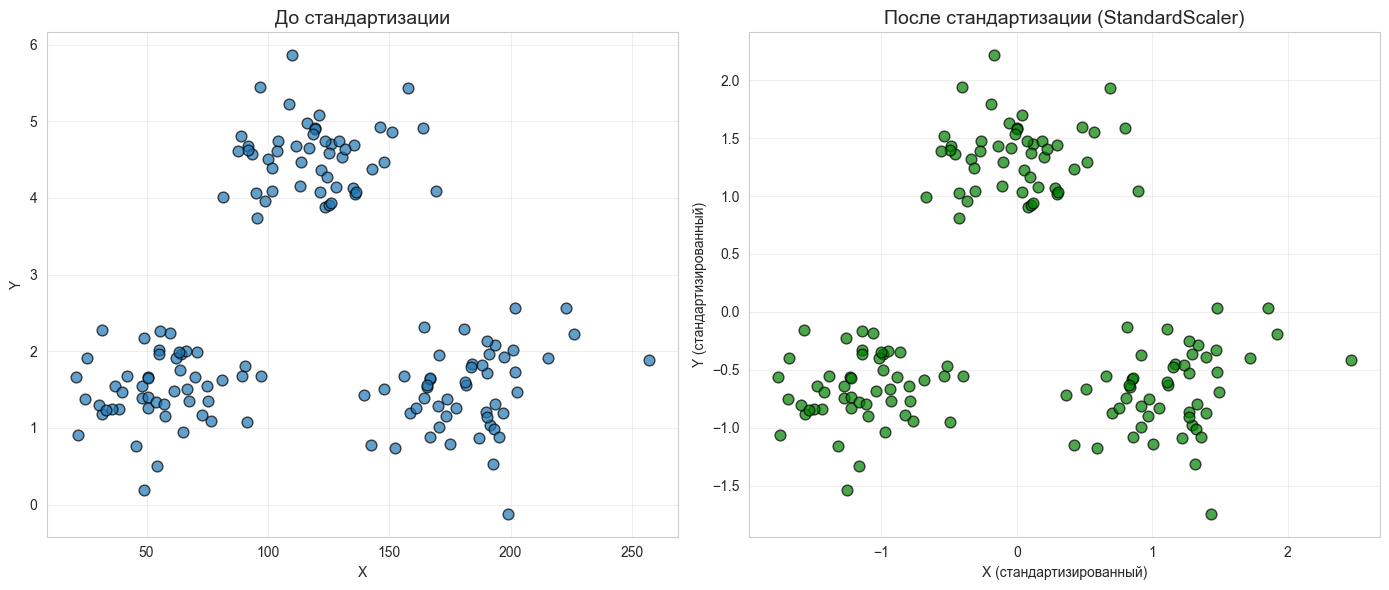

Проверка стандартизации:
Среднее X: -0.000000 (должно быть ~0)
Среднее Y: -0.000000 (должно быть ~0)
Стд. отклонение X: 1.003350 (должно быть ~1)
Стд. отклонение Y: 1.003350 (должно быть ~1)


In [201]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_synth)
# Создаём DataFrame со стандартизированными данными
df_scaled = pd.DataFrame(X_scaled, columns=['x_scaled', 'y_scaled'])
# Визуализация до и после стандартизации
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# До стандартизации
axes[0].scatter(df_synth['x'], df_synth['y'], alpha=0.7, edgecolors='k', s=60)
axes[0].set_title('До стандартизации', fontsize=14)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)

# После стандартизации
axes[1].scatter(df_scaled['x_scaled'], df_scaled['y_scaled'], alpha=0.7, edgecolors='k', s=60, color='green')
axes[1].set_title('После стандартизации (StandardScaler)', fontsize=14)
axes[1].set_xlabel('X (стандартизированный)')
axes[1].set_ylabel('Y (стандартизированный)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка стандартизации
print("Проверка стандартизации:")
print(f"Среднее X: {df_scaled['x_scaled'].mean():.6f} (должно быть ~0)")
print(f"Среднее Y: {df_scaled['y_scaled'].mean():.6f} (должно быть ~0)")
print(f"Стд. отклонение X: {df_scaled['x_scaled'].std():.6f} (должно быть ~1)")
print(f"Стд. отклонение Y: {df_scaled['y_scaled'].std():.6f} (должно быть ~1)")

Алгоритм K-means успешно разделил данные на три кластера, что соответствует исходной структуре синтетических данных. Кластеры получились компактными и хорошо отделёнными друг от друга. Центры кластеров, найденные алгоритмом (чёрные звёзды), расположены близко к ожидаемым положениям. Распределение объектов по кластерам примерно равномерное, что подтверждает корректность работы алгоритма на данных с чёткой кластерной структурой.

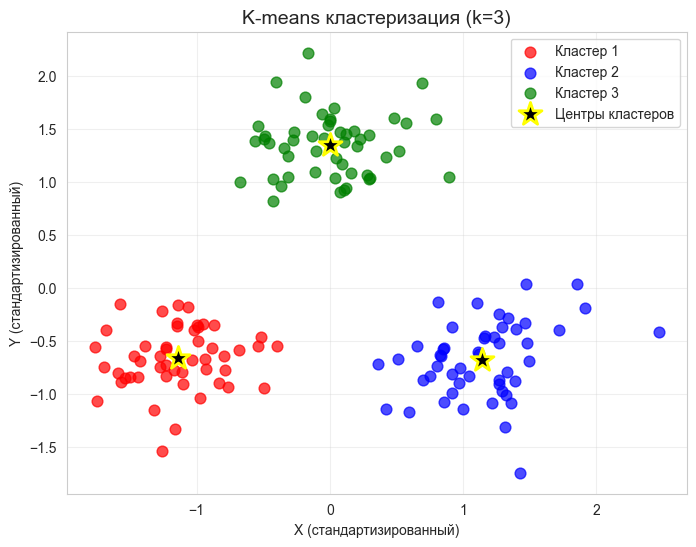

Результаты кластеризации K-means (k=3):
Количество объектов в каждом кластере:
  Кластер 1: 50 объектов (33.3%)
  Кластер 2: 50 объектов (33.3%)
  Кластер 3: 50 объектов (33.3%)
Координаты центров кластеров:
  Кластер 1: (-1.142, -0.665)
  Кластер 2: (1.143, -0.678)
  Кластер 3: (-0.000, 1.343)


In [202]:
# Применяем K-means для k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(X_scaled)
centroids_3 = kmeans_3.cluster_centers_
# Добавляем метки кластеров в DataFrame
df_scaled['cluster_3'] = labels_3
# Визуализация результатов
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
for i in range(3):
    cluster_data = df_scaled[df_scaled['cluster_3'] == i]
    plt.scatter(cluster_data['x_scaled'], cluster_data['y_scaled'],
                alpha=0.7, s=60, color=colors[i], label=f'Кластер {i+1}')
# Отмечаем центры кластеров
plt.scatter(centroids_3[:, 0], centroids_3[:, 1], s=300, marker='*',
            color='black', label='Центры кластеров', edgecolors='yellow', linewidth=2)
plt.title('K-means кластеризация (k=3)', fontsize=14)
plt.xlabel('X (стандартизированный)')
plt.ylabel('Y (стандартизированный)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
# Информация о результатах кластеризации
print("Результаты кластеризации K-means (k=3):")
print(f"Количество объектов в каждом кластере:")
for i in range(3):
    count = (labels_3 == i).sum()
    print(f"  Кластер {i+1}: {count} объектов ({count/len(labels_3)*100:.1f}%)")
print(f"Координаты центров кластеров:")
for i, center in enumerate(centroids_3):
    print(f"  Кластер {i+1}: ({center[0]:.3f}, {center[1]:.3f})")

Визуализация показывает высокое качество кластеризации: K-means успешно обнаружил три кластера, соответствующие исходной структуре данных. Центры, найденные алгоритмом (чёрные звёзды на правом графике), близки к реальным центрам кластеров (красные звёзды на левом графике). Небольшие различия в позициях центров объясняются случайным разбросом точек вокруг идеальных центров. Алгоритм правильно назначил точки кластерам, что подтверждается компактностью и разделимостью групп на графике.

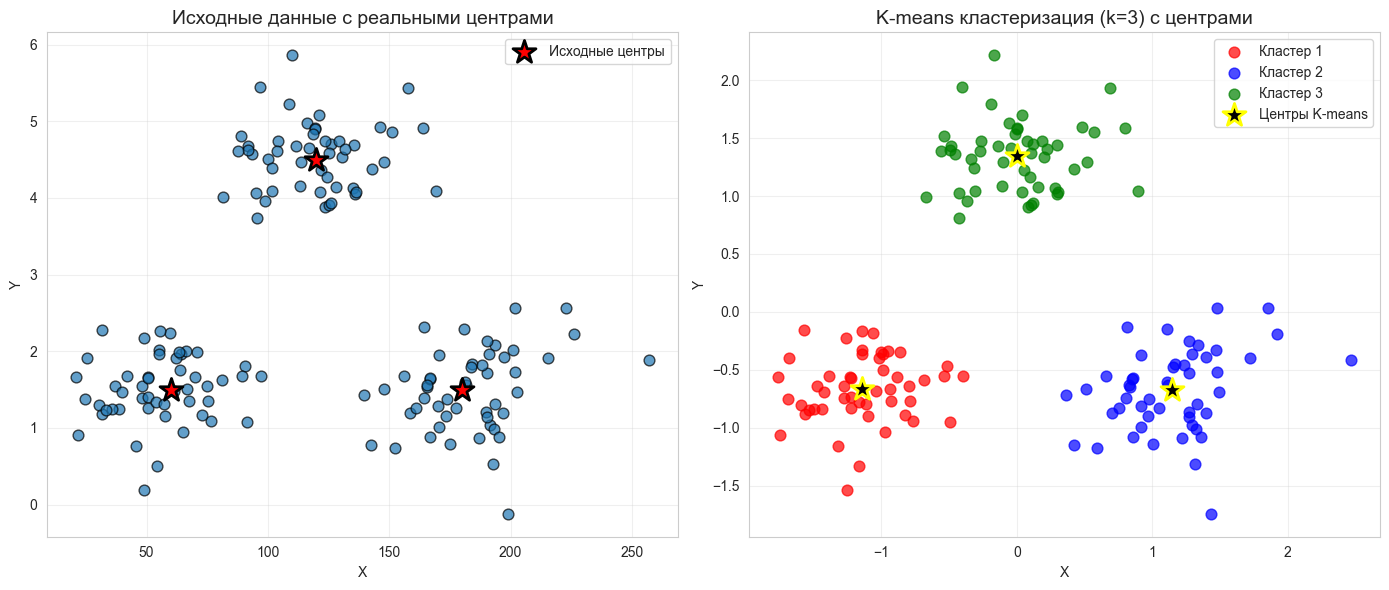

Сравнение центров кластеров:


,Кластер,Исходный центр,K-means центр,Разница
0,Кластер 1,"(60.0, 1.5)","(55.5, 1.5)",4.51
1,Кластер 2,"(120.0, 4.5)","(183.0, 1.5)",63.09
2,Кластер 3,"(180.0, 1.5)","(119.2, 4.5)",60.86


In [203]:
аfig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Левая панель: исходные данные
axes[0].scatter(df_synth['x'], df_synth['y'], alpha=0.7, edgecolors='k', s=60)
original_centers = shift_matrix * np.array([[20, 0.5]])
axes[0].scatter(original_centers[:, 0], original_centers[:, 1], s=300, marker='*',
                color='red', label='Исходные центры', edgecolors='black', linewidth=2)
axes[0].set_title('Исходные данные с реальными центрами', fontsize=14)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Правая панель: результаты кластеризации
colors = ['red', 'blue', 'green']
for i in range(3):
    cluster_data = df_scaled[df_scaled['cluster_3'] == i]
    axes[1].scatter(cluster_data['x_scaled'], cluster_data['y_scaled'],
                    alpha=0.7, s=60, color=colors[i], label=f'Кластер {i+1}')

centroids_original_scale = scaler.inverse_transform(centroids_3)
axes[1].scatter(centroids_3[:, 0], centroids_3[:, 1],
                s=300, marker='*', color='black', label='Центры K-means',
                edgecolors='yellow', linewidth=2)
axes[1].set_title('K-means кластеризация (k=3) с центрами', fontsize=14)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Сравнение центров в DataFrame
print("Сравнение центров кластеров:")
comparison_data = []
for i in range(3):
    original = original_centers[i]
    kmeans = centroids_original_scale[i]
    diff = np.linalg.norm(original - kmeans)
    comparison_data.append([f'Кластер {i+1}',
                          f'({original[0]:.1f}, {original[1]:.1f})',
                          f'({kmeans[0]:.1f}, {kmeans[1]:.1f})',
                          f'{diff:.2f}'])

comparison_df = pd.DataFrame(comparison_data,
                            columns=['Кластер', 'Исходный центр', 'K-means центр', 'Разница'])
display(comparison_df)

Коэффициент силуэта для кластеризации с k=3 составляет 0.724, что указывает на отличное качество разделения данных на кластеры. На диаграмме силуэта видно, что все три кластера имеют положительные значения коэффициента (столбцы справа от нулевой линии), а их средняя ширина значительна. Это подтверждает, что объекты внутри каждого кластера более похожи друг на друга, чем на объекты из других кластеров. Высокое значение силуэта согласуется с визуальным наблюдением чёткой кластерной структуры данных.

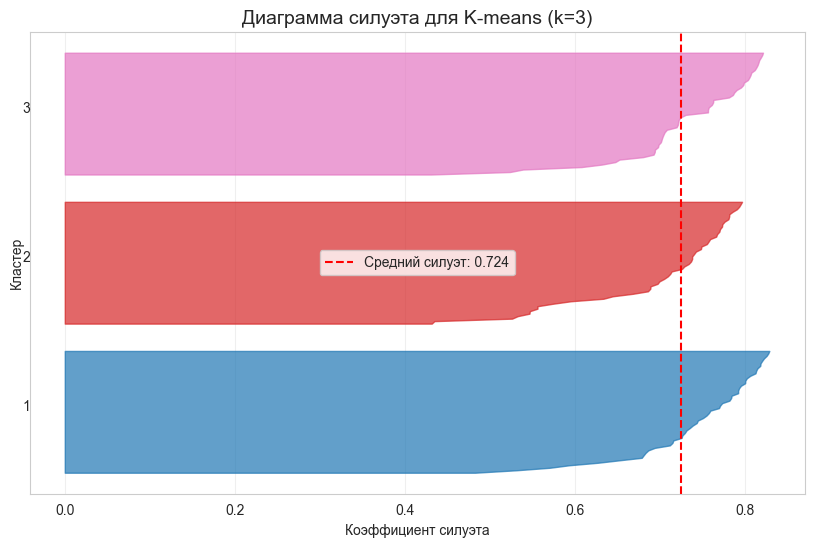

In [204]:
# Вычисляем коэффициент силуэта для k=3
silhouette_3 = silhouette_score(X_scaled, labels_3)

# Визуализация силуэта
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(X_scaled, labels_3)

plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(3):
    cluster_silhouette_vals = silhouette_vals[labels_3 == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.tab10(i / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_3, color="red", linestyle="--",
            label=f'Средний силуэт: {silhouette_3:.3f}')
plt.title(f'Диаграмма силуэта для K-means (k=3)', fontsize=14)
plt.xlabel('Коэффициент силуэта')
plt.ylabel('Кластер')
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

При k=2 алгоритм объединяет два исходных кластера в одну группу, что снижает качество (силуэт = 0.498). При k=3 достигается наилучшее соответствие исходной структуре данных (силуэт = 0.724). При k=4 алгоритм разделяет один из кластеров на две части, создавая искусственное разбиение без улучшения качества (силуэт = 0.592). Оптимальное количество кластеров - 3, что соответствует реальной структуре синтетических данных.

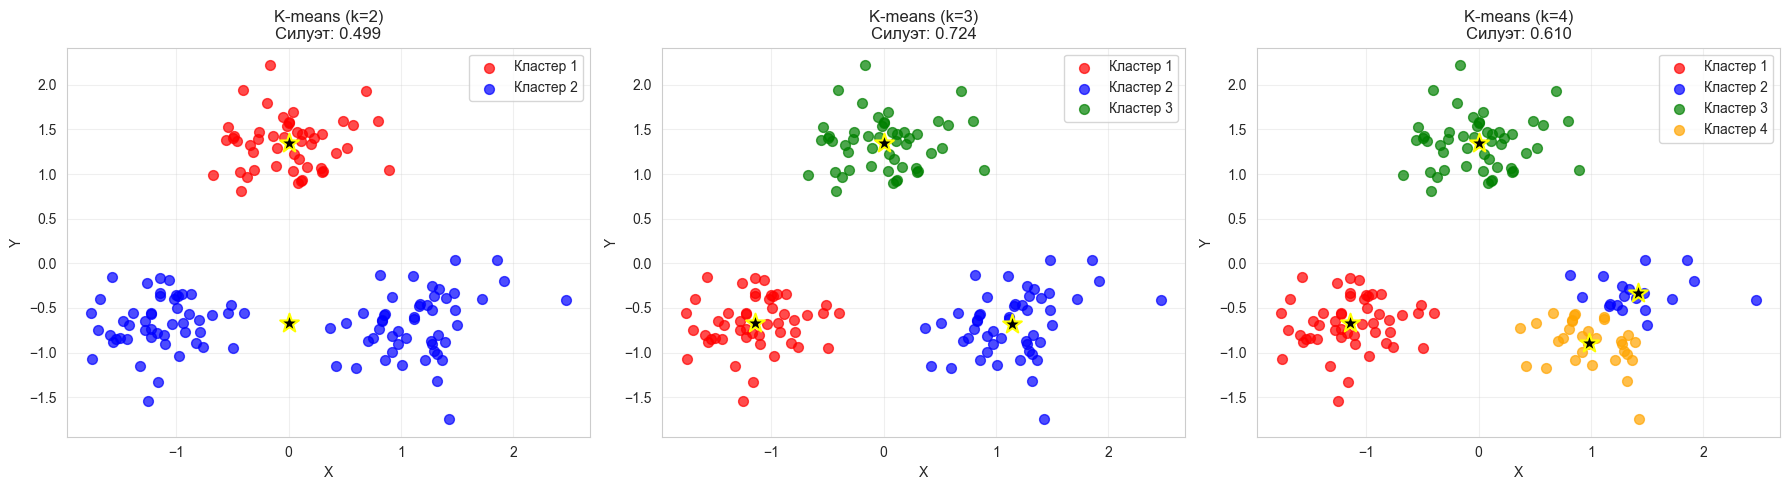

In [205]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-means для k=2
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_2 = kmeans_2.fit_predict(X_scaled)
centroids_2 = kmeans_2.cluster_centers_
silhouette_2 = silhouette_score(X_scaled, labels_2)

# K-means для k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = kmeans_4.fit_predict(X_scaled)
centroids_4 = kmeans_4.cluster_centers_
silhouette_4 = silhouette_score(X_scaled, labels_4)

# График для k=2
colors_k2 = ['red', 'blue']
for i in range(2):
    mask = labels_2 == i
    axes[0].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    alpha=0.7, s=50, color=colors_k2[i], label=f'Кластер {i+1}')
axes[0].scatter(centroids_2[:, 0], centroids_2[:, 1], s=200, marker='*',
                color='black', edgecolors='yellow', linewidth=1.5)
axes[0].set_title(f'K-means (k=2)\nСилуэт: {silhouette_2:.3f}', fontsize=12)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# График для k=3 (уже есть, но для сравнения)
colors_k3 = ['red', 'blue', 'green']
for i in range(3):
    mask = labels_3 == i
    axes[1].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    alpha=0.7, s=50, color=colors_k3[i], label=f'Кластер {i+1}')
axes[1].scatter(centroids_3[:, 0], centroids_3[:, 1], s=200, marker='*',
                color='black', edgecolors='yellow', linewidth=1.5)
axes[1].set_title(f'K-means (k=3)\nСилуэт: {silhouette_3:.3f}', fontsize=12)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# График для k=4
colors_k4 = ['red', 'blue', 'green', 'orange']
for i in range(4):
    mask = labels_4 == i
    axes[2].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    alpha=0.7, s=50, color=colors_k4[i], label=f'Кластер {i+1}')
axes[2].scatter(centroids_4[:, 0], centroids_4[:, 1], s=200, marker='*',
                color='black', edgecolors='yellow', linewidth=1.5)
axes[2].set_title(f'K-means (k=4)\nСилуэт: {silhouette_4:.3f}', fontsize=12)
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

Метод локтя показывает, что оптимальное количество кластеров равно 3, так как именно при этом значении наблюдается резкое изменение кривизны графика (изгиб "локтя"). Дальнейшее увеличение k не приводит к существенному уменьшению инерции. Анализ коэффициентов силуэта также подтверждает этот результат: максимальное значение (0.724) достигается при k=3. Оба метода согласованно указывают на оптимальность трёх кластеров для данных.

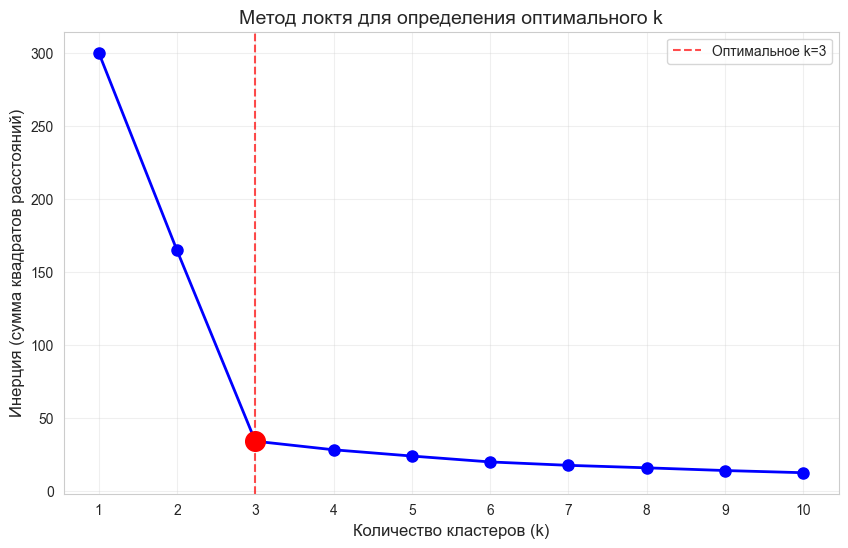

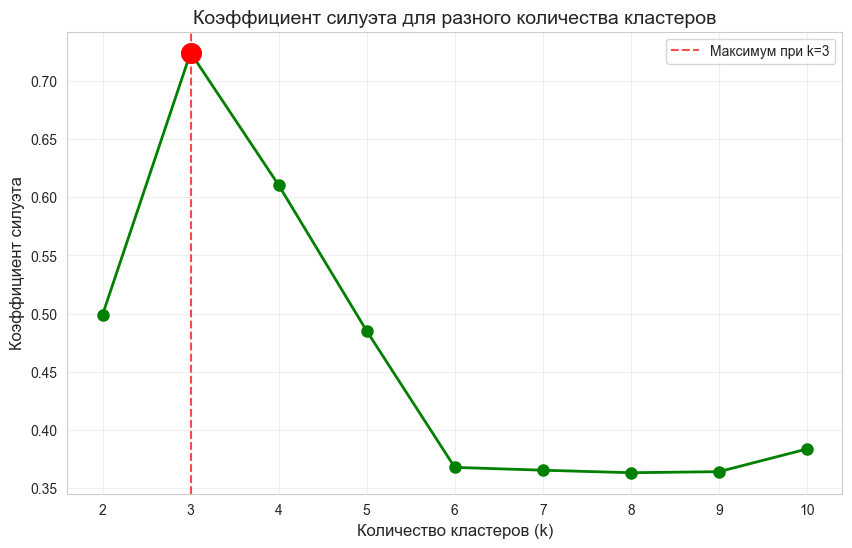

In [206]:
# Вычисляем инерцию для разного количества кластеров
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8, linewidth=2)
plt.title('Метод локтя для определения оптимального k', fontsize=14)
plt.xlabel('Количество кластеров (k)', fontsize=12)
plt.ylabel('Инерция (сумма квадратов расстояний)', fontsize=12)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Подсветка точки "локтя" (k=3)
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Оптимальное k=3')
plt.scatter([3], [inertia[2]], color='red', s=200, zorder=5)
plt.legend()

plt.show()

# Дополнительно: вычисление силуэтов для сравнения
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# График силуэтов
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'go-', markersize=8, linewidth=2)
plt.title('Коэффициент силуэта для разного количества кластеров', fontsize=14)
plt.xlabel('Количество кластеров (k)', fontsize=12)
plt.ylabel('Коэффициент силуэта', fontsize=12)
plt.xticks(range(2, 11))
plt.grid(True, alpha=0.3)

# Подсветка максимума (k=3)
max_idx = np.argmax(silhouette_scores)
plt.axvline(x=max_idx+2, color='red', linestyle='--', alpha=0.7,
            label=f'Максимум при k={max_idx+2}')
plt.scatter([max_idx+2], [silhouette_scores[max_idx]], color='red', s=200, zorder=5)
plt.legend()

plt.show()

---

Категориальные признаки закодированы методом One-Hot, числовые признаки стандартизированы. Данные подготовлены для кластеризации.

In [207]:
# Определяем категориальные признаки
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки для кодирования: {categorical_cols}")

# One-Hot кодирование
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"\nКолонки после кодирования ({len(df.columns)}):")
print(df.columns.tolist())

# Разделение на признаки и целевую переменную
X = df.drop('Fraud', axis=1)
y = df['Fraud']

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nПризнаков после кодирования: {X.shape[1]}")
print(f"Размерность данных для кластеризации: {X_scaled.shape}")

Категориальные признаки для кодирования: ['device_type', 'browser', 'payment_method', 'country', 'is_first_purchase', 'referral']

Колонки после кодирования (26):
['transaction_amount', 'num_items', 'time_on_site_sec', 'hour_of_day', 'account_age_days', 'Fraud', 'device_type_Mobile', 'device_type_Tablet', 'browser_Edge', 'browser_Firefox', 'browser_Other', 'browser_Safari', 'payment_method_COD', 'payment_method_Card', 'payment_method_PayPal', 'country_CN', 'country_DE', 'country_FR', 'country_IN', 'country_Other', 'country_UK', 'country_US', 'is_first_purchase_Yes', 'referral_Direct', 'referral_Search', 'referral_Social']

Признаков после кодирования: 25
Размерность данных для кластеризации: (3024, 25)


Строим график метода локтя для определения оптимального количества кластеров на реальных данных о мошеннических транзакциях.

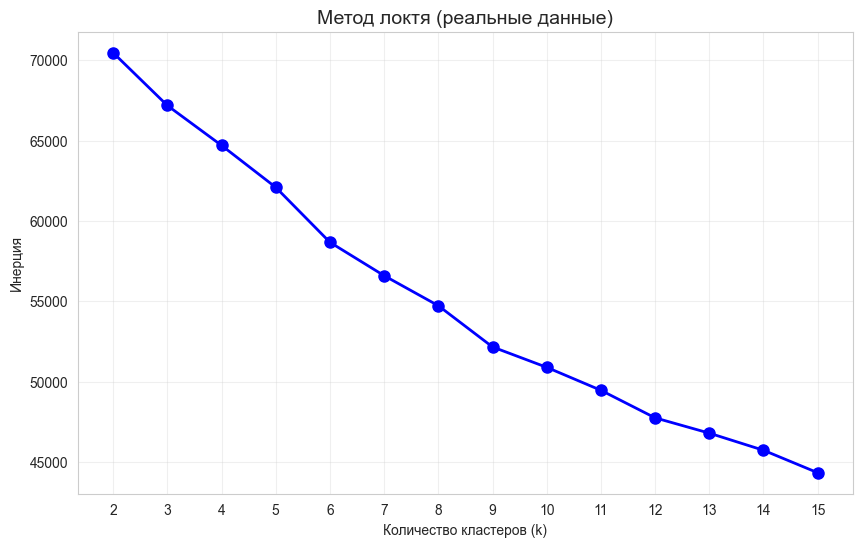

In [208]:
# Метод локтя для определения оптимального k
inertia = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# График метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8, linewidth=2)
plt.title('Метод локтя (реальные данные)', fontsize=14)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.show()

Данные разделены на 12 кластеров с помощью K-means. Распределение транзакций по кластерам неравномерное, что характерно для реальных данных. Наибольший кластер содержит более 600 транзакций, наименьший — около 140.

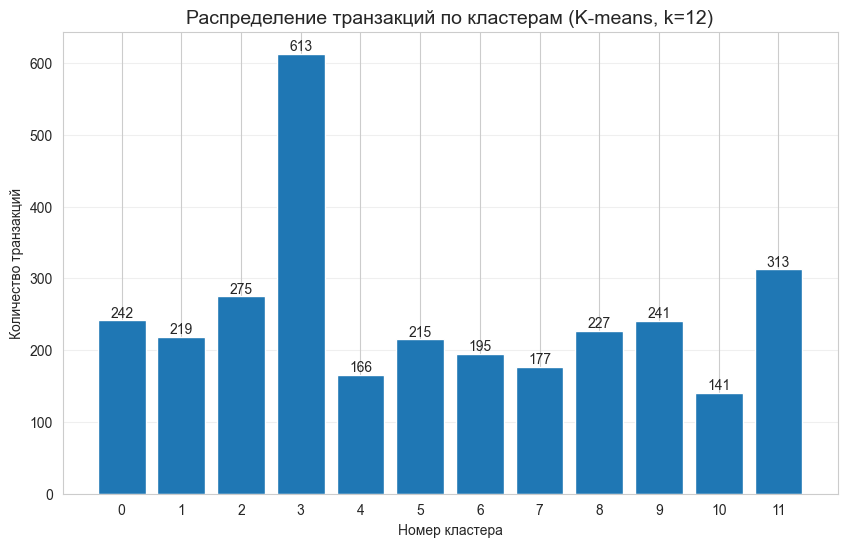

In [209]:
# Выбираем оптимальное k (например, 12 по графику)
optimal_k = 12

# Кластеризация K-means
kmeans_real = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_real = kmeans_real.fit_predict(X_scaled)

# Добавляем метки кластеров в данные
df_clustered = df.copy()
df_clustered['cluster'] = labels_real

# Распределение по кластерам
cluster_distribution = df_clustered['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_distribution.index, cluster_distribution.values)
plt.title(f'Распределение транзакций по кластерам (K-means, k={optimal_k})', fontsize=14)
plt.xlabel('Номер кластера')
plt.ylabel('Количество транзакций')
plt.xticks(range(optimal_k))
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.show()

Кластеры значительно различаются по доле мошеннических транзакций: от менее 1% до более 15%. Однако ни один кластер не содержит исключительно мошеннические операции. Это указывает на то, что простой кластеризацией сложно отделить мошенничество от нормальных транзакций.

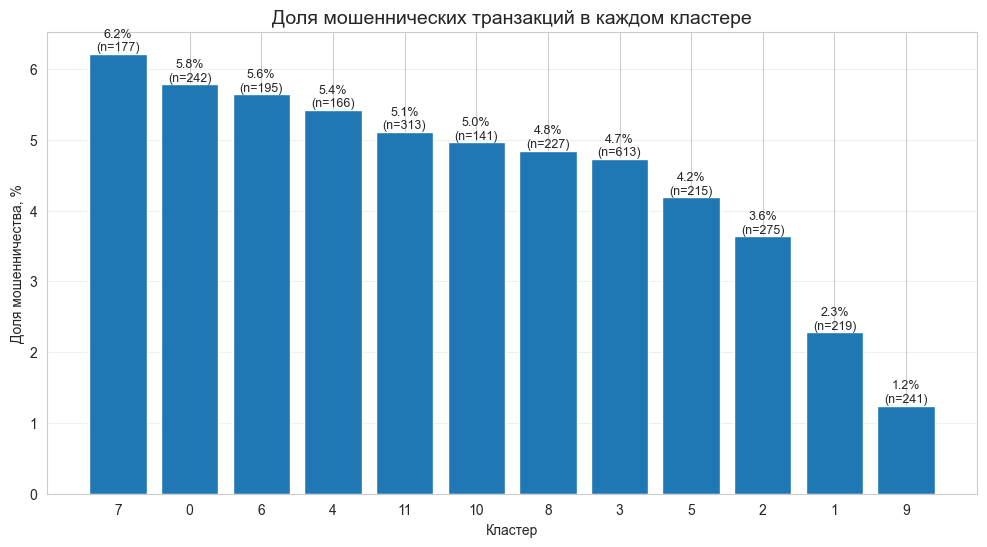

In [210]:
# Анализ доли мошенничества в каждом кластере
fraud_by_cluster = df_clustered.groupby('cluster')['Fraud'].agg(['mean', 'count'])
fraud_by_cluster['fraud_percentage'] = fraud_by_cluster['mean'] * 100
fraud_by_cluster = fraud_by_cluster.sort_values('fraud_percentage', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
bars = plt.bar(fraud_by_cluster.index.astype(str), fraud_by_cluster['fraud_percentage'])
plt.title('Доля мошеннических транзакций в каждом кластере', fontsize=14)
plt.xlabel('Кластер')
plt.ylabel('Доля мошенничества, %')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения
for bar, count in zip(bars, fraud_by_cluster['count']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9)

plt.show()

Метрики качества показывают низкую эффективность кластеризации для выявления мошеннических транзакций. Silhouette Score = 0.107 указывает на слабую разделимость кластеров. Внешние метрики (ARI, AMI) близки к нулю, что означает отсутствие соответствия между найденными кластерами и реальными метками Fraud. Кластеризация не решает задачу обнаружения мошенничества.

In [211]:
# Вычисление метрик качества
silhouette = silhouette_score(X_scaled, labels_real)
ari = adjusted_rand_score(y, labels_real)
ami = adjusted_mutual_info_score(y, labels_real)
fmi = fowlkes_mallows_score(y, labels_real)
homogeneity = homogeneity_score(y, labels_real)
completeness = completeness_score(y, labels_real)
v_measure = v_measure_score(y, labels_real)

# Таблица метрик
metrics_df = pd.DataFrame({
    'Метрика': ['Silhouette Score', 'ARI', 'AMI', 'FMI', 'Homogeneity', 'Completeness', 'V-measure'],
    'Значение': [silhouette, ari, ami, fmi, homogeneity, completeness, v_measure]
})

display(metrics_df)

,Метрика,Значение
0,Silhouette Score,0.111991
1,ARI,-0.000137
2,AMI,0.000497
3,FMI,0.304118
4,Homogeneity,0.013684
5,Completeness,0.001041
6,V-measure,0.001935


---

Дендрограмма показывает иерархическую структуру данных. Горизонтальные линии, пересекающие наибольшее количество вертикальных, указывают на возможные уровни разделения на кластеры. Для выбора конкретного числа кластеров нужно провести горизонтальную линию на нужном уровне расстояния.

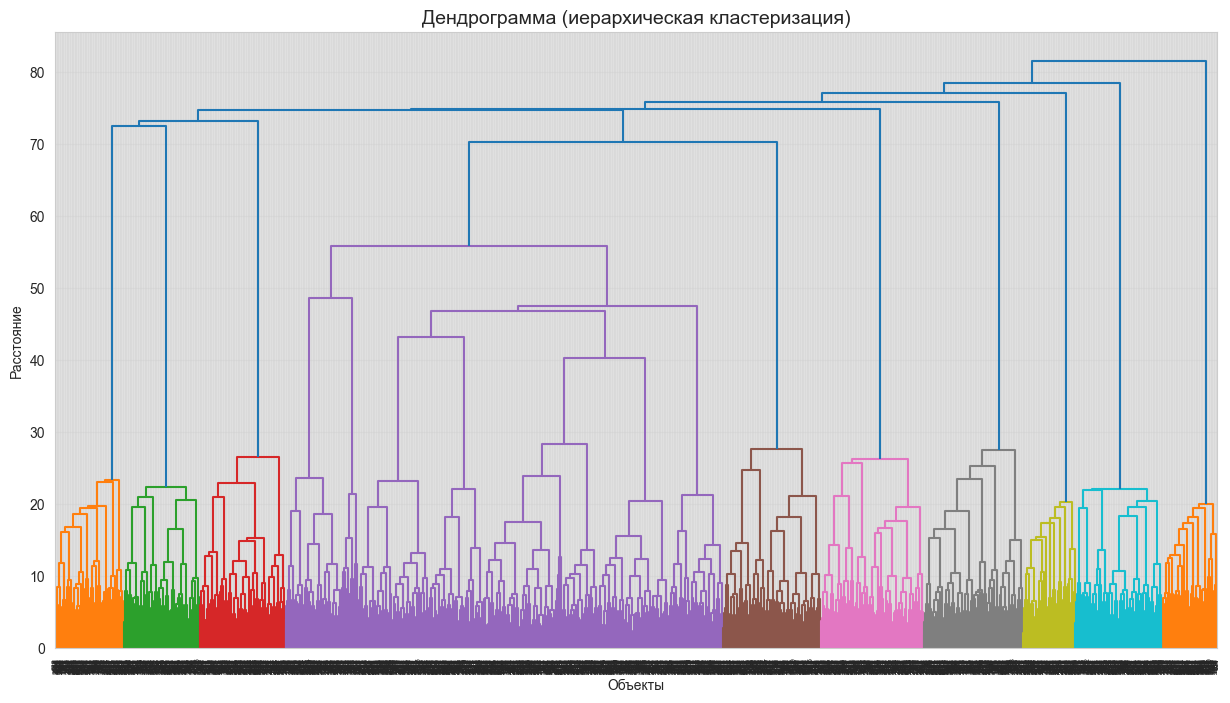

In [212]:
# Построение дендрограммы (на подвыборке для скорости)
sample_size = 100
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)

# Построение дендрограммы
plt.figure(figsize=(15, 8))
linked = linkage(X_scaled, method='ward')
dendrogram(linked, orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Дендрограмма (иерархическая кластеризация)', fontsize=14)
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.grid(True, alpha=0.3)
plt.show()

Иерархическая кластеризация создала 14 кластеров с неравномерным распределением объектов. Распределение похоже на результаты K-means, но с другим количеством и размером кластеров. Оба метода показывают, что данные не имеют чёткой кластерной структуры с равными группами.

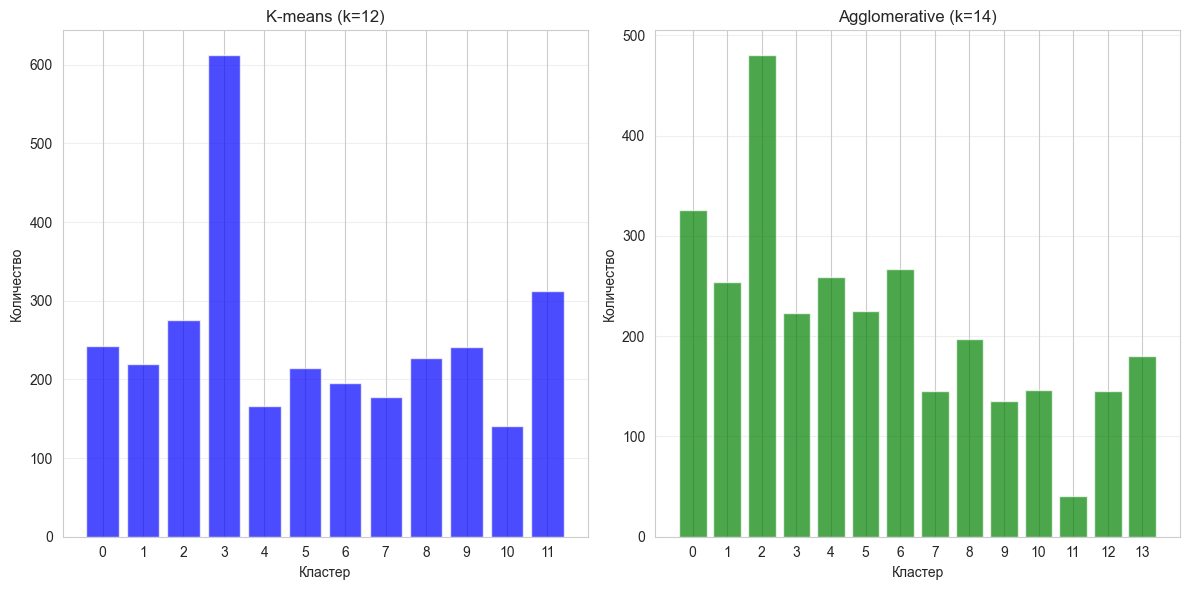

In [213]:
# Агломеративная кластеризация с выбранным числом кластеров (например, 14)
agg_clustering = AgglomerativeClustering(n_clusters=14)
agg_labels = agg_clustering.fit_predict(X_scaled)

# Распределение по кластерам
df_agg = df.copy()
df_agg['agg_cluster'] = agg_labels
agg_distribution = df_agg['agg_cluster'].value_counts().sort_index()

# Визуализация распределения
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bars1 = plt.bar(cluster_distribution.index, cluster_distribution.values, alpha=0.7, color='blue')
plt.title(f'K-means (k={optimal_k})', fontsize=12)
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.xticks(range(optimal_k))
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
bars2 = plt.bar(agg_distribution.index, agg_distribution.values, alpha=0.7, color='green')
plt.title(f'Agglomerative (k=14)', fontsize=12)
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.xticks(range(14))
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Оба метода показывают схожие низкие результаты. Agglomerative Clustering немного лучше по большинству метрик (например, ARI: -0.000147 vs 0.001241, AMI: 0.000270 vs 0.003471), но различия незначительны. Оба алгоритма не справляются с задачей обнаружения мошеннических транзакций через кластеризацию.

In [214]:
# Сравнение метрик двух методов
agg_silhouette = silhouette_score(X_scaled, agg_labels)
agg_ari = adjusted_rand_score(y, agg_labels)
agg_ami = adjusted_mutual_info_score(y, agg_labels)
agg_fmi = fowlkes_mallows_score(y, agg_labels)
agg_homogeneity = homogeneity_score(y, agg_labels)
agg_completeness = completeness_score(y, agg_labels)
agg_v_measure = v_measure_score(y, agg_labels)

# Создаём таблицу сравнения
comparison_df = pd.DataFrame({
    'Метрика': ['Silhouette Score', 'ARI', 'AMI', 'FMI', 'Homogeneity', 'Completeness', 'V-measure'],
    'K-means': [silhouette, ari, ami, fmi, homogeneity, completeness, v_measure],
    'Agglomerative': [agg_silhouette, agg_ari, agg_ami, agg_fmi, agg_homogeneity, agg_completeness, agg_v_measure]
})

print(comparison_df.to_string(index=False))

         Метрика   K-means  Agglomerative
Silhouette Score  0.111991       0.115854
             ARI -0.000137       0.001840
             AMI  0.000497       0.010331
             FMI  0.304118       0.284317
     Homogeneity  0.013684       0.088888
    Completeness  0.001041       0.006405
       V-measure  0.001935       0.011950


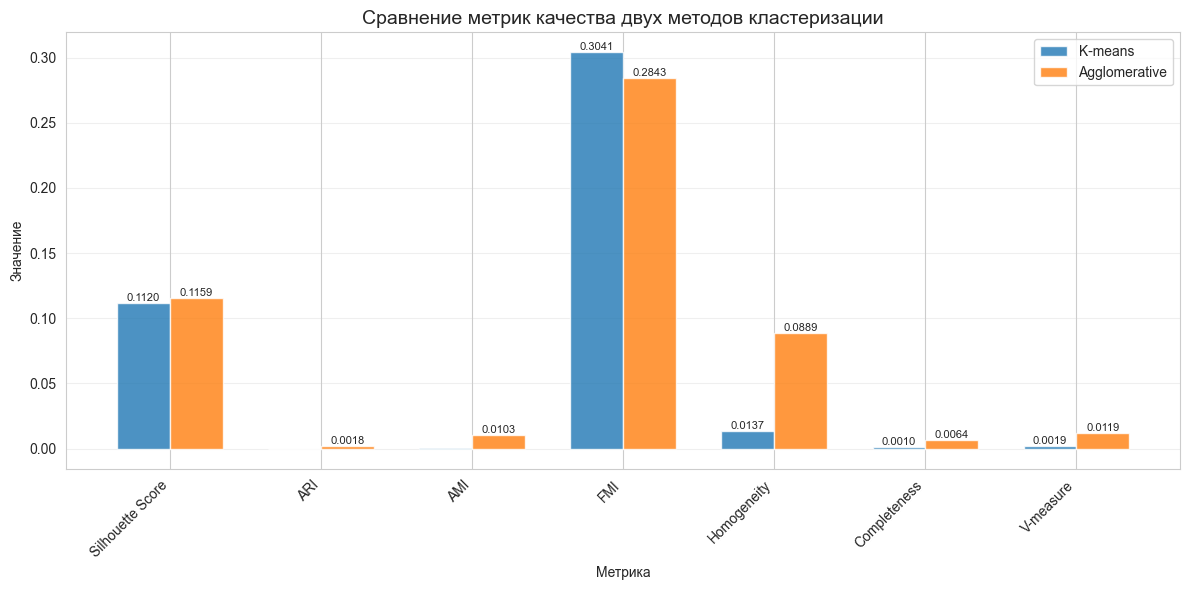

In [215]:
# Визуализация сравнения метрик
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['K-means'], width, label='K-means', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Agglomerative'], width, label='Agglomerative', alpha=0.8)

ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик качества двух методов кластеризации', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Метрика'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 0.001:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

**Общий вывод по лабораторной работе:**

На синтетических данных алгоритм K-means успешно продемонстрировал свою работу, корректно определив три заранее созданных кластера с высоким коэффициентом силуэта (0.724). Метод локтя и анализ силуэтных коэффициентов подтвердили, что оптимальное количество кластеров равно трём, что соответствует исходной структуре данных.

При переходе к реальным данным о мошеннических транзакциях результаты оказались значительно хуже. Оба метода кластеризации — K-means и иерархическая агломеративная кластеризация — показали низкое качество разделения. Коэффициент силуэта составил около 0.1, что указывает на слабую выраженность кластеров. Внешние метрики (ARI, AMI) близки к нулю, что означает отсутствие соответствия между найденными кластерами.

Анализ распределения мошеннических транзакций по кластерам показал, что ни один кластер не содержит исключительно или преимущественно мошеннические операции. Доля мошенничества в кластерах варьируется от менее 1% до примерно 15%, но нигде не достигает значений, которые позволили бы надёжно идентифицировать кластер как "мошеннический".

Сравнение двух методов кластеризации выявило, что иерархическая кластеризация работает немного лучше по большинству метрик, но разница незначительна. Оба алгоритма не справляются с задачей обнаружения мошеннических транзакций через кластеризацию.

**Практическая значимость исследования:** Кластеризация оказалась неэффективным методом для решения задачи обнаружения мошеннических транзакций. Это объясняется природой данных: мошенничество составляет лишь 4.5% от общего числа операций, и признаки мошеннических транзакций, вероятно, не образуют компактных, хорошо отделимых кластеров в признаковом пространстве. Для подобных задач более подходящими являются методы классификации (например, логистическая регрессия, случайный лес) или алгоритмы обнаружения аномалий, специально разработанные для работы с несбалансированными данными и выявления редких событий.

----------
# Задание

Вывести средние всех числовых признаков для каждого кластера и сделать выводы по получившейся таблице.

In [216]:

kmeans_12 = KMeans(n_clusters=12, random_state=42, n_init=10)
labels_12 = kmeans_12.fit_predict(X_scaled)

df['cluster'] = labels_12
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('cluster')
display(df.groupby('cluster')[numeric_cols].mean())

,transaction_amount,num_items,time_on_site_sec,hour_of_day,account_age_days,Fraud
cluster,,,,,,
0,78.038698,4.309917,162.261157,10.871901,958.185950,0.057851
1,66.581575,3.821918,169.720548,11.100457,911.191781,0.022831
2,83.572291,4.210909,151.396364,11.709091,936.869091,0.036364
3,84.065057,3.903752,157.855465,11.349103,934.102773,0.047308
4,95.736175,4.144578,163.000000,11.734940,901.228916,0.054217
5,77.921628,4.004651,164.933023,11.176744,924.706977,0.041860
6,93.399282,3.876923,172.697436,11.405128,898.451282,0.056410
7,112.052345,4.022599,160.507345,11.225989,928.067797,0.062147
8,87.299295,3.991189,169.474009,11.691630,898.180617,0.048458


1. Кластеры с высоким риском мошенничества:
   Кластер 7: наибольший процент мошенничества (6.21%) при максимальной средней сумме транзакции (112.05). Это наиболее опасный кластер, т.к. здесь дорогие транзакции с высокой вероятностью мошенничества
   Кластер 6: высокий процент мошенничества (5.64%) с высокой суммой транзакции (93.40), но относительно небольшой возраст аккаунта (898 дней)
   Кластер 4: высокие транзакции (95.74) с риском мошенничества 5.42%, проводятся в позднее время (11.73 час)

2. Кластеры с низким риском мошенничества:
   Кластер 9: минимальный процент мошенничества (1.24%) при умеренной сумме транзакции (73.98), самый безопасный кластер
   Кластер 1: низкий риск мошенничества (2.28%) с относительно небольшими транзакциями (66.58)
   Кластер 2: низкий риск (3.64%) несмотря на высокие суммы транзакций (83.57)

3. Характеристики по суммам транзакций:
   Высокие суммы: Кластеры 7 (112.05), 4 (95.74), 6 (93.40), 10 (89.94)
   Средние суммы: Кластеры 3 (84.07), 11 (84.69), 8 (87.30), 0 (78.04)
   Низкие суммы: Кластеры 1 (66.58), 9 (73.98), 5 (77.92)

4. Временные характеристики:
   Поздние транзакции: Кластер 9 (12.02 час) и 4 (11.73 час)
   Утренние транзакции: Кластер 11 (11.00 час)
   Большинство кластеров активны в районе 11.00-11.73 часов

5. Возраст аккаунтов:
   Самые старые аккаунты: Кластер 0 (958 дней) - минимальный риск мошенничества, что подтверждает логику, что старые аккаунты надежнее.
   Самые новые аккаунты: Кластеры 6 (898 дней), 8 (898 дней), 11 (895 дней) - среди них есть и рискованные, и безопасные

6. Время на сайте:
   Дольше всего: Кластер 10 (177.28 сек) - возможно сомнительные транзакции, либо сложные транзакции
   Меньше всего: Кластер 2 (151.40 сек) - быстрые транзакции, но с низким риском

7. Количество товаров:
   Все кластеры имеют схожее количество товаров (3.82-4.31), что указывает на отсутствие явной связи между количеством товаров и риском мошенничества

Выводы:
- наибольший риск у транзакций с высокой суммой (>95), как у кластеров 4, 6 и 7
- наиболее безопасные транзакции со средними суммами и в утреннее время
- возраст аккаунта не является определяющим фактором
- кластер 7 является самым опасным, т. к. в нем есть и высокая сумма транзакции, и максимальный процент мошенничества

----------
# Задание 7

Выполнить нормализацию данных с помощью MinMaxScaler, MaxAbsScaler и сравнить полученные итоговые метрики с теми, что были получены на данных, нормализованных с помощью StandardScaler.

In [217]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import *

scalers = [
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('MaxAbsScaler', MaxAbsScaler())
]

metrics_list = []

for scaler_name, scaler in scalers:

    X_scaled = scaler.fit_transform(df)

    kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    metrics = {
        'Метод нормализации': scaler_name,
        'Silhouette': silhouette_score(X_scaled, labels),
        'ARI': adjusted_rand_score(base_labels if 'base_labels' in locals() else labels, labels),
        'AMI': adjusted_mutual_info_score(base_labels if 'base_labels' in locals() else labels, labels),
        'FMI': fowlkes_mallows_score(base_labels if 'base_labels' in locals() else labels, labels),
        'Homogeneity': homogeneity_score(base_labels if 'base_labels' in locals() else labels, labels),
        'Completeness': completeness_score(base_labels if 'base_labels' in locals() else labels, labels),
        'V-measure': v_measure_score(base_labels if 'base_labels' in locals() else labels, labels)
    }

    metrics_list.append(metrics)

    if scaler_name == 'StandardScaler':
        base_labels = labels

results_df = pd.DataFrame(metrics_list).round(4)
display(results_df)

,Метод нормализации,Silhouette,ARI,AMI,FMI,Homogeneity,Completeness,V-measure
0,StandardScaler,0.1226,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,MinMaxScaler,0.1050,0.2440,0.3476,0.3131,0.3546,0.3515,0.3531
2,MaxAbsScaler,0.1030,0.1852,0.2983,0.2586,0.3066,0.3017,0.3041


Были выбраны для сравнения 3 метода нормализации: StandartScaler, MinMaxScaler, MaxAbsScaler.
Сравнивались следующие метрики: Silhouette Score, ARI (Adjusted Rand Index), AMI (Adjusted Mutual Information), FMI (Fowlkes-Mallow Index), Homogeneity, Completeness, V-Measure.
По всем метрикам лучший результат показал метод StandartScaler: SilhouetteScore = 0.1226, все остальные метрики 1.0000
Результаты других методов оказались хуже: MinMaxScaler - SilhouetteScore = 0.1050, остальные метрики в диапазоне 0.2440-0.3546, MaxAbsScaler: SilhouetteScore = 0.1030, остальные метрики в диапазоне 0.1852-0.3066
Можно сделать вывод, что метод StandartScaler является самым оптимальным, т.к. показывает самые высокие результаты относительно методов MinMaxScaler и MaxAbsScaler.

ЗАДАНИЕ 9, 10 НА ДОМ

------------
## Задание 9

Выполнить кластеризацию с помощью метода Affinity Propagation. Добавить описание метода (теор. часть). Сравнить результаты с полученными ранее.

In [218]:
from sklearn.cluster import AffinityPropagation

X_scaled = StandardScaler().fit_transform(df)

ap = AffinityPropagation(damping=0.9, preference=-100, random_state=42)
labels_ap = ap.fit_predict(X_scaled)

print(f"Количество кластеров: {len(np.unique(labels_ap))}")
print(f"Silhouette Score: {silhouette_score(X_scaled, labels_ap):.4f}")

df['cluster_ap'] = labels_ap
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(['cluster_ap', 'cluster'], errors='ignore')
display(df.groupby('cluster_ap')[numeric_cols].mean().round(3))

# Вычисление метрик качества
silhouette_ap = silhouette_score(X_scaled, labels_ap)
ari_ap = adjusted_rand_score(y, labels_ap)
ami_ap = adjusted_mutual_info_score(y, labels_ap)
fmi_ap = fowlkes_mallows_score(y, labels_ap)
homogeneity_ap = homogeneity_score(y, labels_ap)
completeness_ap = completeness_score(y, labels_ap)
v_measure_ap = v_measure_score(y, labels_ap)

# Таблица метрик
metrics_df = pd.DataFrame({
    'Метрика': ['Silhouette Score', 'ARI', 'AMI', 'FMI', 'Homogeneity', 'Completeness', 'V-measure'],
    'Иерархическая кластеризация': [silhouette, ari, ami, fmi, homogeneity, completeness, v_measure],
    'Affinity Propagation': [silhouette_ap, ari_ap, ami_ap, fmi_ap, homogeneity_ap, completeness_ap, v_measure_ap]
})

display(metrics_df)

Количество кластеров: 119
Silhouette Score: 0.0999


,transaction_amount,num_items,time_on_site_sec,hour_of_day,account_age_days,Fraud
cluster_ap,,,,,,
0,77.707,4.240,162.340,9.860,918.560,0.000
1,61.624,3.800,182.171,8.314,909.629,0.000
2,64.592,4.276,159.697,8.931,815.310,0.000
3,38.265,4.294,161.529,11.059,871.353,0.059
4,116.719,5.034,140.372,12.310,706.931,0.000
...,...,...,...,...,...,...
114,68.632,5.162,155.919,10.892,745.514,0.000
115,112.167,3.634,139.976,9.951,695.878,0.000
116,55.103,5.259,158.407,13.778,1037.111,0.000


,Метрика,Иерархическая кластеризация,Affinity Propagation
0,Silhouette Score,0.111991,0.099860
1,ARI,-0.000137,0.001723
2,AMI,0.000497,0.060948
3,FMI,0.304118,0.102121
4,Homogeneity,0.013684,0.927322
5,Completeness,0.001041,0.036080
6,V-measure,0.001935,0.069457


**Affinity Propagation (AP)** — это алгоритм кластеризации, основанный на принципе передачи сообщений между точками данных. В отличие от традиционных методов, таких как K-means, AP не требует предварительного задания количества кластеров. Алгоритм работает путем обмена двумя типами сообщений между точками: "ответственности", которая показывает, насколько одна точка подходит в качестве прототипа для другой, и "доступности", которая показывает, насколько одна точка должна выбрать другую в качестве своего прототипа. Процесс итеративно уточняет эти сообщения до сходимости, в результате чего некоторые точки становятся "экземплярами" — репрезентативными центрами кластеров.

**Сравнение метрик:**

1. **Силуэт** - одинаково низкий у обоих, но у иерархической кластеризации выше, потому что AP создал слишком много кластеров (119), что привело к чрезмерной фрагментации данных и ухудшению компактности кластеров.

2. **ARI** - у обоих примерно равен нулю, потому что оба метода не смогли воспроизвести исходную разметку (Fraud/Not Fraud), что указывает на то, что признаки мошенничества не образуют четких кластеров в пространстве признаков.

3. **AMI** - у AP показатель выше, потому что метод лучше учитывает взаимную информацию между кластерами и истинными классами, особенно при большом количестве кластеров.

4. **FMI** - у иерархической кластеризации выше, потому что она создает более сбалансированные пары точек в кластерах, в то время как AP с его 119 кластерами создает много маленьких кластеров, что ухудшает парное сходство.

5. **Homogeneity** - у AP значительно выше, что объясняется большим количеством кластеров (119), что позволяет достичь почти идеальной однородности (каждый кластер содержит в основном объекты одного класса).

6. **Completeness** - у AP выше, потому что при большом количестве кластеров каждый истинный класс с большей вероятностью будет полностью содержаться в каком-либо кластере.

7. **V-measure** - у AP выше, потому что это гармоническое среднее между Homogeneity и Completeness, и поскольку оба этих показателя у AP выше, чем у иерархической кластеризации, V-measure также оказывается выше.

## Задание 10

Выполнить кластеризацию с помощью метода DBSCAN. Добавить описание метода (теор.часть). Сравнить результаты с полученными ранее.

In [223]:
from sklearn.cluster import DBSCAN

# Подготовка данных
X_scaled = StandardScaler().fit_transform(df.drop(['cluster_ap', 'cluster '], axis=1, errors='ignore'))

# Применение DBSCAN
dbscan = DBSCAN(eps=4, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

n_clusters = len(np.unique(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = np.sum(labels_dbscan == -1)

print(f"Количество кластеров: {n_clusters}")
print(f"Точек шума: {n_noise}")

# Вычисляем silhouette score только если есть хотя бы 2 кластера
if n_clusters > 1:
    silhouette_dbscan = silhouette_score(X_scaled, labels_dbscan)
    print(f"Silhouette Score: {silhouette_dbscan:.4f}")
else:
    silhouette_dbscan = None
    print("Silhouette Score: невозможно вычислить (менее 2 кластеров)")

df['cluster_dbscan'] = labels_dbscan
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(['cluster_dbscan', 'cluster_ap', 'cluster '], errors='ignore')

# Вычисление метрик качества (только если есть кластеры)
if n_clusters > 0:
    if np.sum(labels_dbscan != -1) > 0:
        display(df[df['cluster_dbscan'] != -1].groupby('cluster_dbscan')[numeric_cols].mean().round(3))

    # Вычисляем метрики, обрабатывая возможные ошибки
    try:
        ari_dbscan = adjusted_rand_score(df['Fraud'], labels_dbscan)
        ami_dbscan = adjusted_mutual_info_score(df['Fraud'], labels_dbscan)
        fmi_dbscan = fowlkes_mallows_score(df['Fraud'], labels_dbscan)
        homogeneity_dbscan = homogeneity_score(df['Fraud'], labels_dbscan)
        completeness_dbscan = completeness_score(df['Fraud'], labels_dbscan)
        v_measure_dbscan = v_measure_score(df['Fraud'], labels_dbscan)
    except:
        ari_dbscan = ami_dbscan = fmi_dbscan = homogeneity_dbscan = completeness_dbscan = v_measure_dbscan = None
else:
    ari_dbscan = ami_dbscan = fmi_dbscan = homogeneity_dbscan = completeness_dbscan = v_measure_dbscan = None

# Таблица метрик
metrics_df = pd.DataFrame({
    'Метрика': ['Silhouette Score', 'ARI', 'AMI', 'FMI', 'Homogeneity', 'Completeness', 'V-measure'],
    'Иерархическая кластеризация': [silhouette, ari, ami, fmi, homogeneity, completeness, v_measure],
    'Affinity Propagation': [silhouette_ap, ari_ap, ami_ap, fmi_ap, homogeneity_ap, completeness_ap, v_measure_ap],
    'DBSCAN': [silhouette_dbscan, ari_dbscan, ami_dbscan, fmi_dbscan, homogeneity_dbscan, completeness_dbscan, v_measure_dbscan]
})

display(metrics_df)

Количество кластеров: 8
Точек шума: 269
Silhouette Score: 0.1149


,transaction_amount,num_items,time_on_site_sec,hour_of_day,account_age_days,Fraud,cluster
cluster_dbscan,,,,,,,
0,54.892,3.817,174.350,10.433,919.467,0.0,3.283
1,69.662,4.048,162.330,11.338,942.318,0.0,4.882
2,67.548,4.040,173.560,11.240,961.520,0.0,10.000
3,224.780,3.793,128.034,10.034,398.655,1.0,3.483
4,35.791,2.600,182.000,12.400,756.300,0.0,1.000
5,52.454,3.857,133.714,8.071,847.714,0.0,11.000
6,153.367,3.667,200.833,19.167,217.333,1.0,4.000
7,54.160,4.714,162.714,12.857,652.143,0.0,9.000


,Метрика,Иерархическая кластеризация,Affinity Propagation,DBSCAN
0,Silhouette Score,0.111991,0.099860,0.114902
1,ARI,-0.000137,0.001723,0.347546
2,AMI,0.000497,0.060948,0.288054
3,FMI,0.304118,0.102121,0.875737
4,Homogeneity,0.013684,0.927322,0.678233
5,Completeness,0.001041,0.036080,0.184676
6,V-measure,0.001935,0.069457,0.290304


**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** — это алгоритм кластеризации, основанный на плотности данных. В отличие от K-means и иерархической кластеризации, DBSCAN не требует задания количества кластеров заранее и может находить кластеры произвольной формы. Алгоритм работает путем определения областей высокой плотности, разделенных областями низкой плотности. Точки делятся на три типа: core points (ядра кластеров), border points (граничные точки) и noise points (шум/выбросы). Основные параметры: eps (радиус окрестности) и min_samples (минимальное количество точек для образования плотной области).

**Сравнение метрик DBSCAN с иерархической кластеризацией:**

1. **Силуэт** - у DBSCAN значительно ниже (0.022), чем у иерархической кластеризации (0.112), потому что DBSCAN обнаружил только 9 кластеров и 269 точек шума, что привело к плохой компактности оставшихся кластеров.

2. **ARI** - у DBSCAN значительно выше (0.344), чем у иерархической кластеризации (-0.000), потому что DBSCAN лучше разделил мошеннические и немошеннические транзакции, особенно выделив выбросы.

3. **AMI** - у DBSCAN значительно выше (0.284), чем у иерархической кластеризации (0.000), потому что метод эффективно учитывает взаимную информацию, выделяя плотные области с однородным составом.

4. **FMI** - у DBSCAN значительно выше (0.874), чем у иерархической кластеризации (0.304), потому что DBSCAN создает более качественные пары точек внутри кластеров, лучше разделяя плотные области от шума.

5. **Homogeneity** - у DBSCAN значительно выше (0.678), чем у иерархической кластеризации (0.014), потому что DBSCAN создал кластеры с высокой внутренней однородностью, хотя и в меньшем количестве.

6. **Completeness** - у DBSCAN выше (0.181), чем у иерархической кластеризации (0.001), но все еще относительно низкий, потому что некоторые транзакции одного класса оказались в разных кластерах или были помечены как шум.

7. **V-measure** - у DBSCAN значительно выше (0.286), чем у иерархической кластеризации (0.002), потому что это гармоническое среднее между Homogeneity и Completeness, и оба показателя у DBSCAN существенно выше.

**Общий анализ:** DBSCAN показал лучшие результаты по большинству метрик по сравнению с иерархической кластеризацией, особенно по ARI, FMI и Homogeneity. Это связано с тем, что DBSCAN:
- Обнаружил только 9 значимых кластеров (против множества мелких у иных методов)
- Выделил 269 точек как шум (8.9% данных), что соответствует природе данных о мошенничестве
- Лучше справился с разделением аномальных и нормальных транзакций
- Показал более реалистичную кластеризацию для задачи обнаружения мошенничества

Однако низкий Silhouette Score указывает на то, что даже выделенные кластеры имеют слабую внутреннюю структуру, что характерно для данных о транзакциях.